In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
import skimage.external.tifffile as tiff

from resources.conv_learner import * # important because our ResNet name needs to override theirs
from resources.plots import *
from common import Statistics, dataset_source
from models import ResNet

In [3]:
PATH = "../datasets/yeast_v5"
data_path = Path(PATH)

In [4]:
CLASSES = ('WT', 'mfb1KO', 'mfb1KO_mmr1KO', 'mmr1KO', 'mmm1KO_230', 'num1_110')
NUM_CLASSES = len(CLASSES)
BATCH_SIZE = 64
SIZE = 200
SEED = 5
# set the seeds for experimentation
np.random.seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [5]:
stats_name = "yeast_v5_per_class.dict"
test_dirs, train_dirs = dataset_source(data_path)
stats_dict = Statistics.per_class(test_dirs, train_dirs,save_name=stats_name)

working on: mfb1KO
working on: mfb1KO_mmr1KO
working on: mmr1KO
working on: WT
working on: mmm1KO_230
working on: num1_110


In [6]:
def get_data(path: str, sz, bs, stats):
    create, lbl2index = ImageClassifierData.prepare_from_path(path, val_name='test', bs=bs)
    stats_dict = {lbl2index[key]: val for key, val in stats.items()}
    tfms = tfms_from_stats(stats_dict, sz, aug_tfms=[RandomDihedral()], pad=sz//8) #even without transformations and padding -> failure
    print('\n class to index mapping:\n',lbl2index)
    return create(tfms)

### the eventual sub-function of ImageClassifierData (read_dirs) expects subdirectories for each class: 
### e.g. all "test/cat.png" images should be in a "cat" folder. 

In [7]:
data = get_data(PATH,SIZE, BATCH_SIZE,stats_dict)


 class to index mapping:
 {'WT': 0, 'mfb1KO': 1, 'mfb1KO_mmr1KO': 2, 'mmm1KO_230': 3, 'mmr1KO': 4, 'num1_110': 5}


In [8]:
x, y = next(iter(data.trn_dl))

In [9]:
print(y.size())

torch.Size([64])


/opt/conda/envs/fastai/lib/python3.6/site-packages/matplotlib/axes/_base.py:3124: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=0
  'left=%s, right=%s') % (left, right))


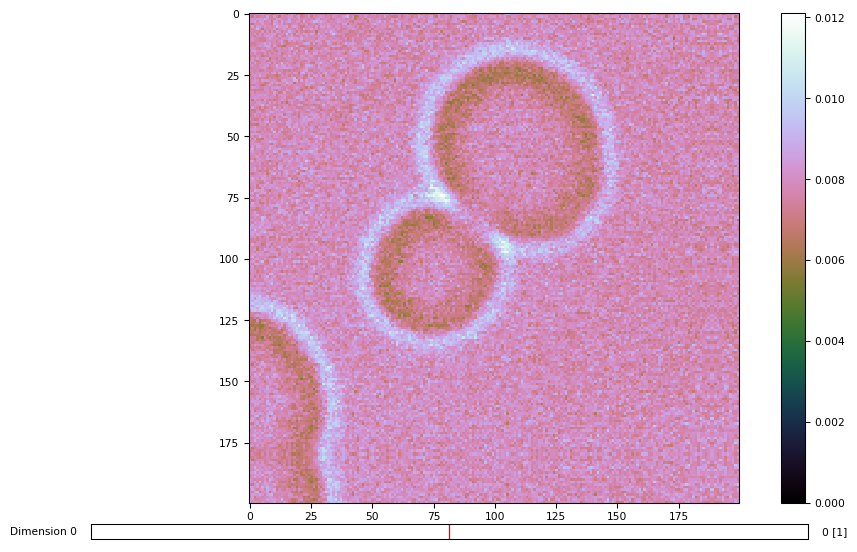

In [10]:
idx = 30
tiff.imshow(data.trn_ds.denorm(x[idx], y[idx]).squeeze()[:,:,0]); #denorm function called has a rollaxis() hence indexing changes.

# Training setup

In [ ]:
class SimpleNet(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        for l in self.layers:
            l_x = l(x)
            x = F.relu(l_x)
        return F.log_softmax(l_x, dim=-1)

In [ ]:
learn = ConvLearner.from_model_data(SimpleNet([200*200*2, 40, NUM_CLASSES]), data) #(!) change channel-number & classes accordingly

In [ ]:
learn, [o.numel() for o in learn.model.parameters()]

In [ ]:
learn.summary()

In [ ]:
lr=1e-5

In [ ]:
%time learn.fit(lr, 200, cycle_len=1)

## ConvNet

In [ ]:
class ConvNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(layers[i], layers[i + 1], kernel_size=5, stride=1, padding=(2,2))
            for i in range(len(layers) - 1)])
        self.pool = nn.AdaptiveMaxPool2d(1)
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        for l in self.layers: x = F.relu(l(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [ ]:
learn = ConvLearner.from_model_data(ConvNet([2, 20, 40, 80], 6), data)

In [ ]:
learn.summary() ### learner.summary is hardcording the number of channels = 3

In [ ]:
lr=1e-10

In [ ]:
%time learn.fit(lr, 10, cycle_len=1)

In [ ]:
torch.cuda.is_available()

## ResNet_with_Batchnorm

In [11]:
class BnLayer(nn.Module):
    def __init__(self, ni, nf, stride=2, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=kernel_size, stride=stride,
                              bias=False, padding=1)
        self.a = nn.Parameter(torch.zeros(nf,1,1))
        self.m = nn.Parameter(torch.ones(nf,1,1))
        
    def forward(self, x):
        x = F.relu(self.conv(x))
        x_chan = x.transpose(0,1).contiguous().view(x.size(1), -1)
        if self.training:
            self.means = x_chan.mean(1)[:,None,None]
            self.stds  = x_chan.std (1)[:,None,None]
        return (x-self.means) / self.stds *self.m + self.a

In [12]:
class ResnetLayer(BnLayer):
    def forward(self, x): return x + super().forward(x)

In [13]:
class Resnet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [14]:
wd=1e-5

In [15]:
learn_hc = ConvLearner.from_model_data(Resnet([10, 20, 40, 80, 160], 6), data)

In [16]:
%time learn_hc.fit(1e-2, 8, cycle_len=4, wds=wd)

EPOCH 0 ---------------                                   
batch distribution:  [22, 21, 5, 14, 30, 5]
[0]:  0.0%
[1]: 64.29%
[2]:  0.0%
[3]: 31.43%
[4]: 100.0%
[5]:  0.0%
epoch      trn_loss   val_loss   accuracy   
    0      14.576533  25.149098  0.253968  
EPOCH 1 ---------------                                   
batch distribution:  [22, 21, 5, 14, 30, 5]
[0]:  0.0%
[1]: 42.86%
[2]:  0.0%
[3]: 45.71%
[4]: 50.0%
[5]:  0.0%
    1      7.969271   8.674541   0.257143  
EPOCH 2 ---------------                                   
batch distribution:  [22, 21, 5, 14, 30, 5]
[0]:  0.0%
[1]: 44.29%
[2]:  0.0%
[3]: 17.14%
[4]: 50.0%
[5]:  0.0%
    2      4.889876   7.796872   0.247619  
EPOCH 3 ---------------                                   
batch distribution:  [22, 21, 5, 14, 30, 5]
[0]:  0.0%
[1]: 42.86%
[2]:  0.0%
[3]: 40.0%
[4]: 58.57%
[5]:  0.0%
    3      3.534072   7.327427   0.260317  
EPOCH 4 ---------------                                   
batch distribution:  [22, 21, 5, 14

[array([3.57721]), 0.46666666742355106]

In [17]:
model1 = ResNet([10, 20, 40, 80, 160], 6, obj_name="EXP",tb_log=False)
learn_exp1 = ConvLearner.from_model_data(model1, data)
%time learn_exp1.fit(1e-2, 8, cycle_len=4, wds=wd)

EPOCH 0 ---------------                                   
batch distribution:  [22, 21, 5, 14, 30, 5]
[0]:  0.0%
[1]: 21.43%
[2]:  0.0%
[3]: 100.0%
[4]: 27.14%
[5]:  0.0%
epoch      trn_loss   val_loss   accuracy   
    0      19.546573  27.691325  0.333333  
EPOCH 1 ---------------                                   
batch distribution:  [22, 21, 5, 14, 30, 5]
[0]:  0.0%
[1]: 57.14%
[2]:  0.0%
[3]: 37.14%
[4]: 60.0%
[5]:  0.0%
    1      11.318616  16.038361  0.285714  
EPOCH 2 ---------------                                   
batch distribution:  [22, 21, 5, 14, 30, 5]
[0]:  0.0%
[1]: 77.14%
[2]:  0.0%
[3]: 17.14%
[4]: 55.71%
[5]:  0.0%
    2      6.811897   12.35904   0.288889  
EPOCH 3 ---------------                                   
batch distribution:  [22, 21, 5, 14, 30, 5]
[0]:  0.0%
[1]: 72.86%
[2]:  0.0%
[3]: 37.14%
[4]: 54.29%
[5]:  0.0%
    3      4.661259   12.267664  0.295238  
EPOCH 4 ---------------                                   
batch distribution:  [22, 21, 5, 

[array([4.9318]), 0.36507936479553343]

In [18]:
model = ResNet([10, 20, 40, 80, 160], 6, obj_name="EXP", tb_log=True)
learn_exp2 = ConvLearner.from_model_data(model, data)
%time learn_exp2.fit(1e-2, 8, cycle_len=4, wds=wd)

EPOCH 0 ---------------                                   
batch distribution:  [22, 21, 5, 14, 30, 5]
[0]:  0.0%
[1]: 48.57%
[2]:  0.0%
[3]: 22.86%
[4]: 50.0%
[5]: 2.857%
epoch      trn_loss   val_loss   accuracy   
    0      15.712452  11.548308  0.228571  
f1 weighted average score: [0.1569]
  0%|          | 0/21 [00:00<?, ?it/s]

/opt/conda/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


EPOCH 1 ---------------                                   
batch distribution:  [22, 21, 5, 14, 30, 5]
[0]: 80.0%
[1]:  0.0%
[2]:  0.0%
[3]: 45.71%
[4]: 50.0%
[5]:  0.0%
    1      8.42825    6.840355   0.231746  
f1 weighted average score: [0.1689]
EPOCH 2 ---------------                                   
batch distribution:  [22, 21, 5, 14, 30, 5]
[0]: 14.29%
[1]: 32.86%
[2]:  0.0%
[3]: 40.0%
[4]: 65.71%
[5]:  0.0%
    2      5.07913    7.207547   0.247619  
f1 weighted average score: [0.1868]
  0%|          | 0/21 [00:00<?, ?it/s]

/opt/conda/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


EPOCH 3 ---------------                                   
batch distribution:  [22, 21, 5, 14, 30, 5]
[0]: 34.29%
[1]: 41.43%
[2]:  0.0%
[3]: 42.86%
[4]: 51.43%
[5]:  0.0%
    3      3.388255   6.681377   0.244444  
f1 weighted average score: [0.1889]
  0%|          | 0/21 [00:00<?, ?it/s]

/opt/conda/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


EPOCH 4 ---------------                                   
batch distribution:  [22, 21, 5, 14, 30, 5]
[0]: 51.43%
[1]: 5.714%
[2]:  0.0%
[3]: 40.0%
[4]: 50.0%
[5]:  0.0%
    4      2.740393   6.048422   0.257143  
f1 weighted average score: [0.2043]
  0%|          | 0/21 [00:00<?, ?it/s]

/opt/conda/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


EPOCH 5 ---------------                                   
batch distribution:  [22, 21, 5, 14, 30, 5]
[0]: 12.86%
[1]: 8.571%
[2]:  0.0%
[3]: 48.57%
[4]: 37.14%
[5]: 2.857%
    5      2.205514   4.863347   0.346032  
f1 weighted average score: [0.325]
EPOCH 6 ---------------                                   
batch distribution:  [22, 21, 5, 14, 30, 5]
[0]: 31.43%
[1]: 15.71%
[2]:  0.0%
[3]: 40.0%
[4]: 41.43%
[5]:  0.0%
    6      1.793773   4.397145   0.250794  
f1 weighted average score: [0.1909]
EPOCH 7 ---------------                                   
batch distribution:  [22, 21, 5, 14, 30, 5]
[0]: 14.29%
[1]: 38.57%
[2]:  0.0%
[3]: 37.14%
[4]: 55.71%
[5]:  0.0%
    7      1.505336   4.351654   0.247619  
f1 weighted average score: [0.1928]
EPOCH 8 ---------------                                   
batch distribution:  [22, 21, 5, 14, 30, 5]
[0]: 7.143%
[1]: 50.0%
[2]:  0.0%
[3]: 34.29%
[4]: 24.29%
[5]: 22.86%
    8      1.637196   4.850899   0.266667  
f1 weighted average score

/opt/conda/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


EPOCH 13 ---------------                                  
batch distribution:  [22, 21, 5, 14, 30, 5]
[0]: 1.429%
[1]: 58.57%
[2]:  0.0%
[3]: 37.14%
[4]: 48.57%
[5]: 20.0%
    13     1.098733   3.349653   0.35873   
f1 weighted average score: [0.3556]
EPOCH 14 ---------------                                   
batch distribution:  [22, 21, 5, 14, 30, 5]
[0]: 8.571%
[1]: 51.43%
[2]:  0.0%
[3]: 31.43%
[4]: 18.57%
[5]: 14.29%
    14     0.99091    3.636735   0.273016  
f1 weighted average score: [0.182]
EPOCH 15 ---------------                                   
batch distribution:  [22, 21, 5, 14, 30, 5]
[0]:  0.0%
[1]: 45.71%
[2]:  0.0%
[3]: 31.43%
[4]: 47.14%
[5]: 14.29%
    15     0.905331   3.823841   0.295238  
f1 weighted average score: [0.2565]
EPOCH 16 ---------------                                  
batch distribution:  [22, 21, 5, 14, 30, 5]
[0]: 7.143%
[1]: 11.43%
[2]:  0.0%
[3]: 31.43%
[4]: 71.43%
[5]: 42.86%
    16     1.153238   2.344879   0.434921  
f1 weighted average s

/opt/conda/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


EPOCH 22 ---------------                                   
batch distribution:  [22, 21, 5, 14, 30, 5]
[0]: 1.429%
[1]: 57.14%
[2]:  0.0%
[3]: 34.29%
[4]: 21.43%
[5]: 68.57%
    22     0.85826    2.02734    0.374603  
f1 weighted average score: [0.2741]
  0%|          | 0/21 [00:00<?, ?it/s]

/opt/conda/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


EPOCH 23 ---------------                                   
batch distribution:  [22, 21, 5, 14, 30, 5]
[0]: 1.429%
[1]: 38.57%
[2]:  0.0%
[3]: 31.43%
[4]: 47.14%
[5]: 68.57%
    23     0.764573   1.783445   0.473016  
f1 weighted average score: [0.4327]
EPOCH 24 ---------------                                   
batch distribution:  [22, 21, 5, 14, 30, 5]
[0]: 8.571%
[1]: 22.86%
[2]:  0.0%
[3]: 37.14%
[4]: 60.0%
[5]: 62.86%
    24     0.92814    4.071473   0.47619   
f1 weighted average score: [0.485]
EPOCH 25 ---------------                                   
batch distribution:  [22, 21, 5, 14, 30, 5]
[0]: 2.857%
[1]: 15.71%
[2]:  0.0%
[3]: 42.86%
[4]: 50.0%
[5]: 51.43%
    25     0.996341   2.031806   0.479365  
f1 weighted average score: [0.463]
EPOCH 26 ---------------                                   
batch distribution:  [22, 21, 5, 14, 30, 5]
[0]: 4.286%
[1]: 17.14%
[2]:  0.0%
[3]: 42.86%
[4]: 48.57%
[5]: 60.0%
    26     0.887166   2.160646   0.415873  
f1 weighted average s

[array([1.52068]), 0.4857142879849389]

In [22]:
learn = learn_exp2

In [26]:
sorted(os.listdir('../datasets/yeast_v5/models'))

['Objective_A_Resnet_per_class_1.h5',
 'Objective_A_Resnet_per_class_balanced_fromstart_1.h5',
 'Objective_A_Resnet_per_class_balanced_fromstart_2.h5',
 'Objective_C_Resnet_per_class_3.h5',
 'Objective_C_Resnet_per_class_balanced_1.h5',
 'Objective_C_Resnet_per_dataset_2.h5',
 'Objective_C_Resnet_per_dataset_3.h5',
 'ResNet5_default_07-24_23-18.h5',
 'ResNet5_v5_batch_adj_07-24_16-46.h5',
 'ResNet5_v5_batch_adj_07-24_18-32.h5',
 'ResNet5_v5_batch_adj_07-24_18-55.h5',
 'ResNet5_v5_batch_adj_07-24_19-11.h5',
 'ResNet5_v5_batch_adj_07-24_19-32.h5',
 'ResNet5_v5_batch_adj_07-24_19-55.h5',
 'ResNet5_v5_batch_adj_07-24_19-59.h5',
 'ResNet5_v5_batch_adj_07-24_20-27.h5']

In [23]:
# at very little overfitting we have 43% accuracy
%time learn.fit(1e-2, 8, wds=wd, cycle_len=10, use_clr=(20,8, 0.95, 0.85), best_save_name=learn.model.tag)

EPOCH 0 ---------------                                    
batch distribution:  [22, 21, 5, 14, 30, 5]
[0]: 8.571%
[1]: 70.0%
[2]:  0.0%
[3]: 45.71%
[4]: 2.857%
[5]: 68.57%
epoch      trn_loss   val_loss   accuracy   
    0      0.638168   2.327813   0.473016  
f1 weighted average score: [0.397]
EPOCH 1 ---------------                                    
batch distribution:  [22, 21, 5, 14, 30, 5]
[0]: 1.429%
[1]: 34.29%
[2]:  0.0%
[3]: 45.71%
[4]: 54.29%
[5]: 60.0%
    1      0.707171   2.138245   0.492063  
f1 weighted average score: [0.4817]
EPOCH 2 ---------------                                    
batch distribution:  [22, 21, 5, 14, 30, 5]
[0]: 37.14%
[1]: 8.571%
[2]:  0.0%
[3]: 48.57%
[4]: 25.71%
[5]: 51.43%
    2      0.715854   1.715517   0.479365  
f1 weighted average score: [0.4443]
EPOCH 3 ---------------                                    
batch distribution:  [22, 21, 5, 14, 30, 5]
[0]: 40.0%
[1]: 37.14%
[2]:  0.0%
[3]: 42.86%
[4]: 31.43%
[5]: 71.43%
    3      0.722359

/opt/conda/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


EPOCH 13 ---------------                                   
batch distribution:  [22, 21, 5, 14, 30, 5]
[0]: 30.0%
[1]: 55.71%
[2]:  0.0%
[3]: 48.57%
[4]: 15.71%
[5]: 71.43%
    13     0.570694   1.817978   0.549206  
f1 weighted average score: [0.497]
EPOCH 14 ---------------                                   
batch distribution:  [22, 21, 5, 14, 30, 5]
[0]: 20.0%
[1]: 50.0%
[2]:  0.0%
[3]: 48.57%
[4]: 41.43%
[5]: 85.71%
    14     0.5915     1.411549   0.501587  
f1 weighted average score: [0.4449]
EPOCH 15 ---------------                                   
batch distribution:  [22, 21, 5, 14, 30, 5]
[0]: 10.0%
[1]: 57.14%
[2]:  0.0%
[3]: 37.14%
[4]: 37.14%
[5]: 82.86%
    15     0.582649   1.576363   0.552381  
f1 weighted average score: [0.533]
EPOCH 16 ---------------                                   
batch distribution:  [22, 21, 5, 14, 30, 5]
[0]: 7.143%
[1]: 64.29%
[2]:  0.0%
[3]: 37.14%
[4]: 38.57%
[5]: 77.14%
    16     0.555907   1.354455   0.546032  
f1 weighted average sc

[0]: 17.14%
[1]: 32.86%
[2]:  0.0%
[3]: 42.86%
[4]: 61.43%
[5]: 74.29%
    45     0.409378   1.160529   0.638095  
f1 weighted average score: [0.6496]
EPOCH 46 ---------------                                   
batch distribution:  [22, 21, 5, 14, 30, 5]
[0]: 17.14%
[1]: 38.57%
[2]:  0.0%
[3]: 45.71%
[4]: 57.14%
[5]: 77.14%
    46     0.413742   0.867401   0.752381  
f1 weighted average score: [0.753]
EPOCH 47 ---------------                                   
batch distribution:  [22, 21, 5, 14, 30, 5]
[0]: 18.57%
[1]: 64.29%
[2]:  0.0%
[3]: 48.57%
[4]: 35.71%
[5]: 74.29%
    47     0.415166   1.505638   0.590476  
f1 weighted average score: [0.5566]
EPOCH 48 ---------------                                   
batch distribution:  [22, 21, 5, 14, 30, 5]
[0]: 30.0%
[1]: 51.43%
[2]:  0.0%
[3]: 48.57%
[4]: 38.57%
[5]: 85.71%
    48     0.388437   1.017486   0.657143  
f1 weighted average score: [0.6492]
EPOCH 49 ---------------                                   
batch distribution:  [22, 

    77     0.355387   1.130597   0.619048  
f1 weighted average score: [0.6023]
EPOCH 78 ---------------                                   
batch distribution:  [22, 21, 5, 14, 30, 5]
[0]: 25.71%
[1]: 58.57%
[2]:  0.0%
[3]: 45.71%
[4]: 42.86%
[5]: 71.43%
    78     0.337332   1.154519   0.650794  
f1 weighted average score: [0.6436]
EPOCH 79 ---------------                                   
batch distribution:  [22, 21, 5, 14, 30, 5]
[0]: 22.86%
[1]: 44.29%
[2]:  0.0%
[3]: 45.71%
[4]: 54.29%
[5]: 74.29%
    79     0.32731    0.933642   0.730159  
f1 weighted average score: [0.733]

CPU times: user 20min 34s, sys: 8min 20s, total: 28min 55s
Wall time: 19min 19s


[array([0.93364]), 0.7301587261850871]

In [27]:
%time learn.fit(1e-3, 8, wds=wd, cycle_len=20, use_clr=(20,8, 0.95, 0.85), best_save_name=learn.model.tag)

EPOCH 0 ---------------                                    
batch distribution:  [22, 21, 5, 14, 30, 5]
[0]: 22.86%
[1]: 52.86%
[2]:  0.0%
[3]: 45.71%
[4]: 35.71%
[5]: 74.29%
epoch      trn_loss   val_loss   accuracy   
    0      0.29158    1.029396   0.666667  
f1 weighted average score: [0.6622]
EPOCH 1 ---------------                                    
batch distribution:  [22, 21, 5, 14, 30, 5]
[0]: 28.57%
[1]: 50.0%
[2]:  0.0%
[3]: 48.57%
[4]: 42.86%
[5]: 80.0%
    1      0.299866   0.903718   0.746032  
f1 weighted average score: [0.7429]
EPOCH 2 ---------------                                    
batch distribution:  [22, 21, 5, 14, 30, 5]
[0]: 22.86%
[1]: 45.71%
[2]:  0.0%
[3]: 48.57%
[4]: 48.57%
[5]: 82.86%
    2      0.311934   0.878561   0.746032  
f1 weighted average score: [0.7485]
EPOCH 3 ---------------                                    
batch distribution:  [22, 21, 5, 14, 30, 5]
[0]: 22.86%
[1]: 50.0%
[2]:  0.0%
[3]: 48.57%
[4]: 41.43%
[5]: 80.0%
    3      0.303084

[0]: 30.0%
[1]: 52.86%
[2]:  0.0%
[3]: 45.71%
[4]: 55.71%
[5]: 85.71%
    64     0.25172    0.718689   0.8       
f1 weighted average score: [0.7979]
EPOCH 65 ---------------                                   
batch distribution:  [22, 21, 5, 14, 30, 5]
[0]: 30.0%
[1]: 55.71%
[2]:  0.0%
[3]: 51.43%
[4]: 52.86%
[5]: 82.86%
    65     0.261352   0.727001   0.780952  
f1 weighted average score: [0.7776]
EPOCH 66 ---------------                                   
batch distribution:  [22, 21, 5, 14, 30, 5]
[0]: 28.57%
[1]: 55.71%
[2]:  0.0%
[3]: 51.43%
[4]: 52.86%
[5]: 85.71%
    66     0.258826   0.720258   0.780952  
f1 weighted average score: [0.779]
EPOCH 67 ---------------                                   
batch distribution:  [22, 21, 5, 14, 30, 5]
[0]: 35.71%
[1]: 52.86%
[2]:  0.0%
[3]: 51.43%
[4]: 58.57%
[5]: 85.71%
    67     0.263055   0.682974   0.8       
f1 weighted average score: [0.7996]
EPOCH 68 ---------------                                   
batch distribution:  [22, 2

    96     0.268528   0.702797   0.806349  
f1 weighted average score: [0.8059]
EPOCH 97 ---------------                                   
batch distribution:  [22, 21, 5, 14, 30, 5]
[0]: 37.14%
[1]: 55.71%
[2]:  0.0%
[3]: 45.71%
[4]: 54.29%
[5]: 82.86%
    97     0.260868   0.699999   0.806349  
f1 weighted average score: [0.8056]
EPOCH 98 ---------------                                   
batch distribution:  [22, 21, 5, 14, 30, 5]
[0]: 37.14%
[1]: 55.71%
[2]:  0.0%
[3]: 45.71%
[4]: 57.14%
[5]: 82.86%
    98     0.262228   0.696031   0.803175  
f1 weighted average score: [0.8029]
EPOCH 99 ---------------                                   
batch distribution:  [22, 21, 5, 14, 30, 5]
[0]: 34.29%
[1]: 55.71%
[2]:  0.0%
[3]: 45.71%
[4]: 58.57%
[5]: 80.0%
    99     0.247419   0.686093   0.815873  
f1 weighted average score: [0.8154]
EPOCH 100 ---------------                                  
batch distribution:  [22, 21, 5, 14, 30, 5]
[0]: 34.29%
[1]: 55.71%
[2]:  0.0%
[3]: 45.71%
[4]: 

EPOCH 129 ---------------                                  
batch distribution:  [22, 21, 5, 14, 30, 5]
[0]: 32.86%
[1]: 54.29%
[2]:  0.0%
[3]: 45.71%
[4]: 54.29%
[5]: 82.86%
   129     0.244801   0.66884    0.8       
f1 weighted average score: [0.7991]
EPOCH 130 ---------------                                  
batch distribution:  [22, 21, 5, 14, 30, 5]
[0]: 31.43%
[1]: 57.14%
[2]:  0.0%
[3]: 45.71%
[4]: 55.71%
[5]: 80.0%
   130     0.239734   0.674355   0.806349  
f1 weighted average score: [0.8062]
EPOCH 131 ---------------                                  
batch distribution:  [22, 21, 5, 14, 30, 5]
[0]: 31.43%
[1]: 52.86%
[2]:  0.0%
[3]: 42.86%
[4]: 61.43%
[5]: 80.0%
   131     0.243996   0.651457   0.819048  
f1 weighted average score: [0.8203]
EPOCH 132 ---------------                                  
batch distribution:  [22, 21, 5, 14, 30, 5]
[0]: 34.29%
[1]: 54.29%
[2]:  0.0%
[3]: 45.71%
[4]: 60.0%
[5]: 80.0%
   132     0.23613    0.647949   0.819048  
f1 weighted average 

[array([0.62728]), 0.8317460372334435]

In [ ]:
learn.load('Objective_C_Resnet_per_class_3')

In [ ]:
%time learn.fit(1e-3, 8, wds=wd, cycle_len=10, use_clr=(20,8, 0.95, 0.85), best_save_name=learn.model.tag)

In [ ]:
%time learn.fit(1e-3, 1, wds=wd, cycle_len=1, use_clr=(20,8, 0.95, 0.85))

In [ ]:
log_preds

In [ ]:
# analyze results 
log_preds, y = learn.TTA(n_aug=1)
log_preds_mean = np.mean(log_preds, axis=0)
preds = np.argmax(log_preds_mean, axis=1)
# cm = confusion_matrix(preds,y)
cm = confusion_matrix(y, preds)
plot_confusion_matrix(cm, data.classes)